In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign() #collect the element-wise sign of the data gradient
    perturbed_image = image + epsilon*sign_data_grad #adjust pixels
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [3]:
# Test function
def test(model, device, test_loader, epsilon):
    correct = 0
    total = 0
    adv_examples = []

    label_translation = {0:0, 217:1, 482:2, 491:3, 497:4, 566:5, 569:6, 571:7, 574:8, 701:9}
    label_indices = torch.tensor(list(label_translation.keys())).to(device)
    
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)

        init_pred_filter = torch.index_select(output, 1, label_indices)
        init_pred = init_pred_filter.max(1, keepdim=True)[1]
        
        #if the initial prediction is wrong continue
        if init_pred.item() != target.item():
            continue

        loss = nn.CrossEntropyLoss()(output, target)

        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred_filter = torch.index_select(output, 1, label_indices)
        final_pred = final_pred_filter.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

        total += 1

    accuracy = correct/float(total)
    print("Epsilon: {}\tAccuracy = {} / {} = {}".format(epsilon, correct, total, accuracy))

    return accuracy, adv_examples

In [4]:
# Define the dataset and data loader for the test set
weights = ResNet50_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

# Apply it to the input image
test_set = datasets.ImageFolder('imagenette2-320/val', transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

model = resnet50(weights=weights)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

accuracies = []
examples = []

epsilons = [0, .05, .1, .15, .2, .25, .3, .4, .5]
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    
# save the accuracies and examples
torch.save(accuracies, 'fgsm_accuracies.pt')
torch.save(examples, 'fgsm_examples.pt')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:34<00:00, 18.28it/s]


Epsilon: 0	Accuracy = 3221 / 3912 = 0.8233640081799591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:31<00:00, 18.56it/s]


Epsilon: 0.05	Accuracy = 3255 / 3912 = 0.8320552147239264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:20<00:00, 19.60it/s]


Epsilon: 0.1	Accuracy = 3126 / 3912 = 0.799079754601227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:13<00:00, 20.26it/s]


Epsilon: 0.15	Accuracy = 2930 / 3912 = 0.7489775051124744


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:32<00:00, 18.48it/s]


Epsilon: 0.2	Accuracy = 2715 / 3912 = 0.6940184049079755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:15<00:00, 20.12it/s]


Epsilon: 0.25	Accuracy = 2544 / 3912 = 0.6503067484662577


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:12<00:00, 20.34it/s]


Epsilon: 0.3	Accuracy = 2404 / 3912 = 0.614519427402863


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:25<00:00, 19.12it/s]


Epsilon: 0.4	Accuracy = 2110 / 3912 = 0.5393660531697342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3925/3925 [03:16<00:00, 19.99it/s]


Epsilon: 0.5	Accuracy = 1898 / 3912 = 0.48517382413087934


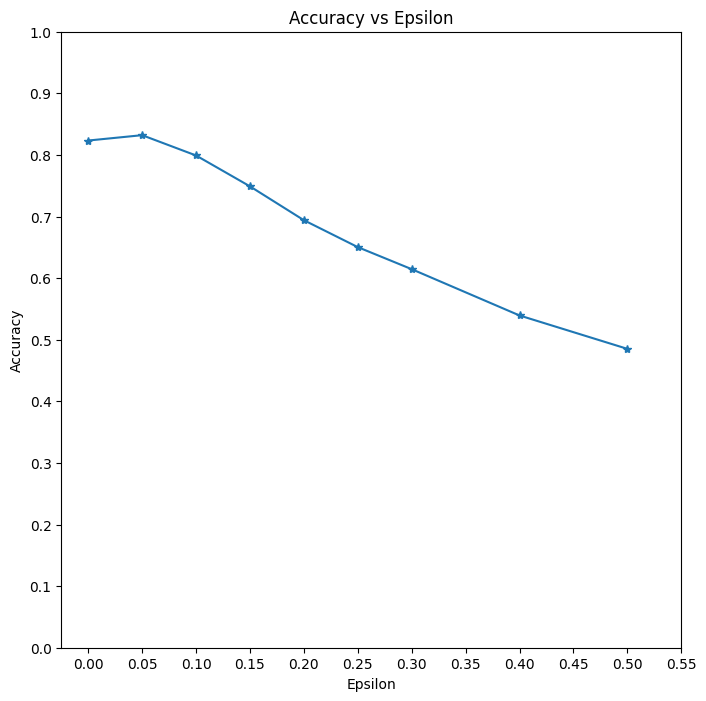

In [12]:
plt.figure(figsize=(8,8))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.60, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


5 3


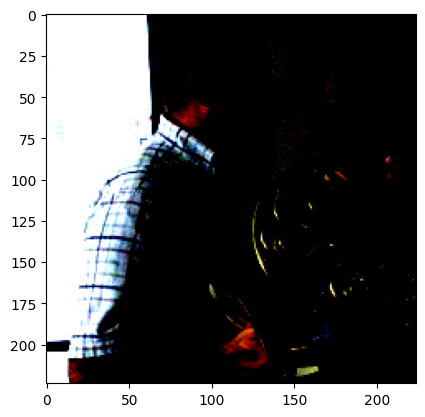

In [36]:
# plt
# for i in range(len(epsilons)):
#     for j in range(len(examples[i])):
#         orig,adv,ex = examples[i][j]
#         ex = ex.transpose(1,2,0)
#         plt.imshow(ex)
e = torch.load("examples2.pt")


In [ ]:
l = {0:0, 217:1, 482:2, 491:3, 497:4, 566:5, 569:6, 571:7, 574:8, 701:9}
indx = list(l.keys())

4 9


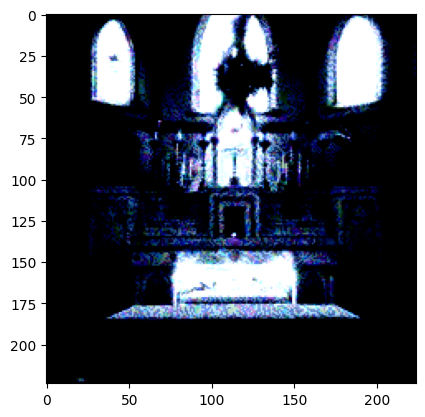

In [55]:
orig,adv,ex = e[3][4]
ex = ex.transpose(1,2,0)
plt.imshow(ex)
print(orig, adv)

In [50]:
len(e[3])

5

In [ ]:
# t.max(1, keepdim=True)
tt = torch.index_select(t, 1, torch.tensor(indx))
tt.max(1, keepdim=True)[1]